In [95]:
import os
import sys
sys.path.insert(0,'..')

import time
import numpy as np
import pandas as pd
import pickle as pkl

from particlenet import ParticleNet

import torch
import torch.nn as nn
import torch_geometric
from torch_geometric.loader import DataListLoader, DataLoader
from torch_geometric.data import Data, Batch

from itertools import cycle
from sklearn.metrics import roc_curve, auc
%matplotlib inline

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import mplhep as hep
plt.style.use(hep.style.CMS)
plt.rcParams.update({'font.size': 20})

from tqdm.notebook import tqdm

# TEST LRP: dR and M_ij

In [4]:
! ls ParticleNet_depth2/Rscores_best/

R_edges.pkl       batch_py.pkl      batch_y.pkl       time_minutes.json
batch_E.pkl       batch_pz.pkl      edge_index.pkl
batch_px.pkl      batch_x.pkl       time_hours.json


In [13]:
def get_dr_Mij(trained=True):
    dr_top, dr_qcd = [], []
    Mij_top, Mij_qcd = [], []
        
    if trained:
        loops = 1    
    else:
        loops = 10
        
    for loop, models in enumerate(range(loops)):
        
        if trained:
            PATH = "ParticleNet_6/Rscores_best_10k"                                           
        else:
            PATH = f"ParticleNet_6/Rscores_{loop}"

        with open(f'{PATH}/batch_x.pkl', 'rb') as handle:
            batch_x_list = pkl.load(handle)
        with open(f'{PATH}/batch_y.pkl', 'rb') as handle:
            batch_y_list = pkl.load(handle)

        with open(f'{PATH}/R_edges.pkl', 'rb') as handle:
            R_edges_list = pkl.load(handle)    
        with open(f'{PATH}/edge_index.pkl', 'rb') as handle:
            edge_index_list = pkl.load(handle)

        with open(f'{PATH}/batch_px.pkl', 'rb') as handle:
            batch_px_list = pkl.load(handle)
        with open(f'{PATH}/batch_py.pkl', 'rb') as handle:
            batch_py_list = pkl.load(handle)  
        with open(f'{PATH}/batch_pz.pkl', 'rb') as handle:
            batch_pz_list = pkl.load(handle)
        with open(f'{PATH}/batch_E.pkl', 'rb') as handle:
            batch_E_list = pkl.load(handle)     
        print(f'loop {loop}')
        for i in tqdm(range(len(batch_y_list))):
            jet_label = batch_y_list[i]
            jet_input = batch_x_list[i]

            R_edges = R_edges_list[i]
            edge_index = edge_index_list[i]

            if trained:        
                R_edges = R_edges['edge_conv_2']
                edge_index = edge_index['edge_conv_2']

            px = batch_px_list[i]
            py = batch_py_list[i]
            pz = batch_pz_list[i]
            e = batch_E_list[i]

            p = torch.sqrt(torch.square(px) + torch.square(py) + torch.square(pz))

            # recall: Features, in order: [eta, phi, pt, mask].
            eta = jet_input[:, 0]
            phi = jet_input[:, 1]
            pt = np.abs(jet_input[:, 2])

            eta_phi = jet_input[:, :2]

            # build graph
            edge_index, edge_weight = edge_index, torch.abs(R_edges).sum(axis=1)
            edge_Rscores = edge_weight/sum(edge_weight)  # normalize sum of Rscores of all jets to be 1

            def deltaR(eta1, eta2, phi1, phi2):
                return torch.sqrt(torch.square(eta2-eta1) + torch.square(phi2-phi1))

            top_5_edges = torch.topk(edge_Rscores, 5).indices   # pick top 5 edge Rscores, get the indices

            for edge in top_5_edges:
                particle_1 = edge_index[0][edge]
                particle_2 = edge_index[1][edge]

                px1 = px[particle_1]
                py1 = py[particle_1]
                pz1 = pz[particle_1]

                px2 = px[particle_2]
                py2 = py[particle_2]
                pz2 = pz[particle_2]

                eta1 = eta[particle_1]
                eta2 = eta[particle_2]

                phi1 = phi[particle_1]
                phi2 = phi[particle_2]

                e1 = e[particle_1]
                e2 = e[particle_2]

                M12 = torch.sqrt(torch.square(e1+e2) - torch.square(px1+ px2) - torch.square(py1+py2) - torch.square(pz1+pz2))

                if jet_label==1:
                    dr_top.append(deltaR(eta1, eta2, phi1, phi2).item())
                    Mij_top.append(M12)
                else:
                    dr_qcd.append(deltaR(eta1, eta2, phi1, phi2).item())
                    Mij_qcd.append(M12) 

    return dr_top, dr_qcd, Mij_top, Mij_qcd, px, jet_input

## Make and save

In [ ]:
dr_top_trained, dr_qcd_trained, Mij_top_trained, Mij_qcd_trained = get_dr_Mij(trained=True)

with open('paper/dr_top_trained.pkl', 'wb') as f:
    pkl.dump(dr_top_trained, f)
with open('paper/dr_qcd_trained.pkl', 'wb') as f:
    pkl.dump(dr_qcd_trained, f)

In [ ]:
dr_top_untrained, dr_qcd_untrained, _, _ = get_dr_Mij(trained=False)

with open('paper/dr_top_untrained.pkl', 'wb') as f:
    pkl.dump(dr_top_untrained, f)
with open('paper/dr_qcd_untrained.pkl', 'wb') as f:
    pkl.dump(dr_qcd_untrained, f) 

## Load and plot

In [2]:
# load the trained vars
with open('paper/dr_top_trained.pkl', 'rb') as f:
    dr_top_trained = pkl.load(f)
with open('paper/dr_qcd_trained.pkl', 'rb') as f:
    dr_qcd_trained = pkl.load(f)
with open('paper/Mij_top_trained.pkl', 'rb') as f:
    Mij_top_trained = pkl.load(f)
with open('paper/Mij_qcd_trained.pkl', 'rb') as f:
    Mij_qcd_trained = pkl.load(f)

In [5]:
# load the untrained vars
with open('paper/dr_top_untrained.pkl', 'rb') as f:
    dr_top_untrained = pkl.load(f)
with open('paper/dr_qcd_untrained.pkl', 'rb') as f:
    dr_qcd_untrained = pkl.load(f)
with open('paper/Mij_top_untrained.pkl', 'rb') as f:
    Mij_top_untrained = pkl.load(f)
with open('paper/Mij_qcd_untrained.pkl', 'rb') as f:
    Mij_qcd_untrained = pkl.load(f) 

<ipython-input-9-8eef36f96eca>:18: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.
  axes[0].set_ylim(0,20)
<ipython-input-9-8eef36f96eca>:28: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.
  axes[1].set_ylim(0,20)


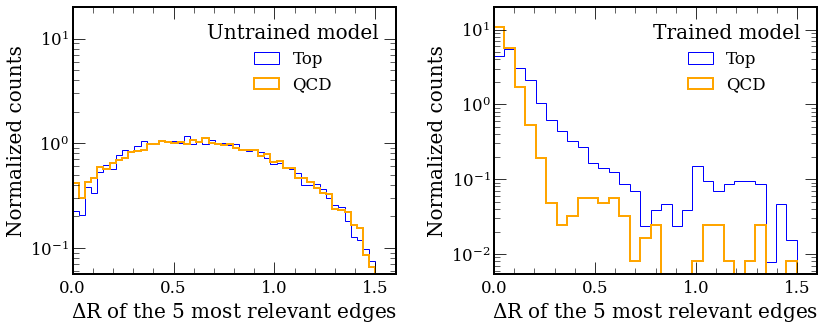

In [9]:
from matplotlib.font_manager import FontProperties

font = FontProperties()
# font.set_family('serif')
font.set_name('Times New Roman')
plt.rcParams.update({'font.family':'serif'}) 
    
# make the plot
fig, axes = plt.subplots(ncols=2, figsize=(12,5))
counts, bins, _ = axes[0].hist(dr_top_untrained, bins=np.linspace(0, 1.5, 50), label='Top', color="Blue", histtype='step', linewidth=1, density=True)
# err = np.sqrt(counts)
# axes[0].errorbar(bins[:-1], counts, yerr=err)
counts, bins, _ = axes[0].hist(dr_qcd_untrained, bins=np.linspace(0, 1.5, 50), label='QCD', color="Orange", histtype='step', linewidth=2, density=True)
# err = np.sqrt(counts)
# axes[0].errorbar(bins[:-1], counts, yerr=err)
axes[0].legend(title='Untrained model')
axes[0].set_yscale('log') 
axes[0].set_ylim(0,20)
axes[0].set_xlim(0,1.6)
axes[0].set_xticks([0,0.5,1,1.5])
axes[0].set_xlabel('$\Delta$R of the 5 most relevant edges')
axes[0].set_ylabel('Normalized counts')

axes[1].hist(dr_top_trained, bins=np.linspace(0, 1.5, 30), label='Top', color="Blue", histtype='step', linewidth=1, density=True)
axes[1].hist(dr_qcd_trained, bins=np.linspace(0, 1.5, 30), label='QCD', color="Orange", histtype='step', linewidth=2, density=True)
axes[1].legend(title='Trained model')
axes[1].set_yscale('log') 
axes[1].set_ylim(0,20)
axes[1].set_xlim(0,1.6)
axes[1].set_xticks([0,0.5,1,1.5])
axes[1].set_xlabel('$\Delta$R of the 5 most relevant edges')
axes[1].set_ylabel('Normalized counts')

fig.tight_layout()

plt.savefig('paper/deltaR.pdf')
plt.show()

<ipython-input-10-7e74385734da>:15: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.
  axes[0].set_ylim(0,20)
<ipython-input-10-7e74385734da>:22: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.
  axes[1].set_ylim(0,20)


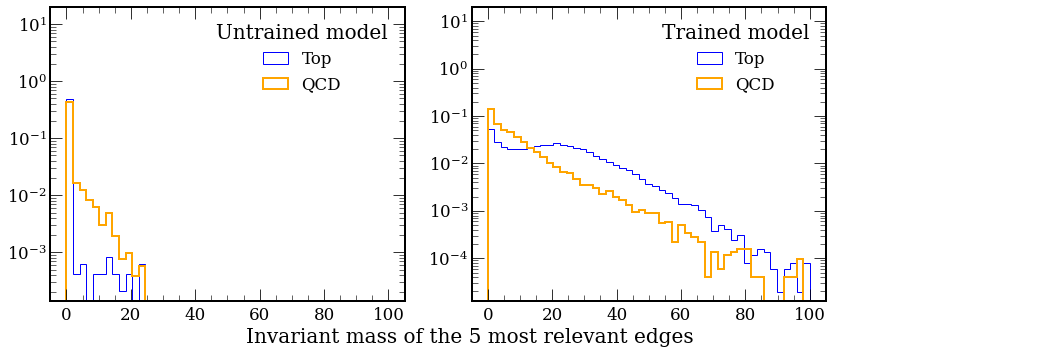

In [10]:
from matplotlib.font_manager import FontProperties

font = FontProperties()
# font.set_family('serif')
font.set_name('Times New Roman')
# plt.rcParams.update({'font.family':'sans-serif'}) 
plt.rcParams.update({'font.family':'serif'}) 

# make the plot
fig, axes = plt.subplots(ncols=2, figsize=(12,5))
axes[0].hist(Mij_top_untrained, bins=np.linspace(0, 100), label='Top', color="Blue", histtype='step', linewidth=1, density=True)
axes[0].hist(Mij_qcd_untrained, bins=np.linspace(0, 100), label='QCD', color="Orange", histtype='step', linewidth=2, density=True)
axes[0].legend(title='Untrained model')
axes[0].set_yscale('log') 
axes[0].set_ylim(0,20)
# axes[0].set_xlabel('Invariant mass of the 5 most relevant edges')

axes[1].hist(Mij_top_trained, bins=np.linspace(0, 100), label='Top', color="Blue",histtype='step', linewidth=1, density=True)
axes[1].hist(Mij_qcd_trained, bins=np.linspace(0, 100), label='QCD', color="Orange",   histtype='step', linewidth=2, density=True)
axes[1].legend(title='Trained model')
axes[1].set_yscale('log') 
axes[1].set_ylim(0,20)

# axes[1].set_xlabel('Invariant mass of the 5 most relevant edges')
fig.tight_layout()

plt.xlabel('Invariant mass of the 5 most relevant edges                                                        ')

plt.savefig('paper/Mij.pdf')
plt.show()

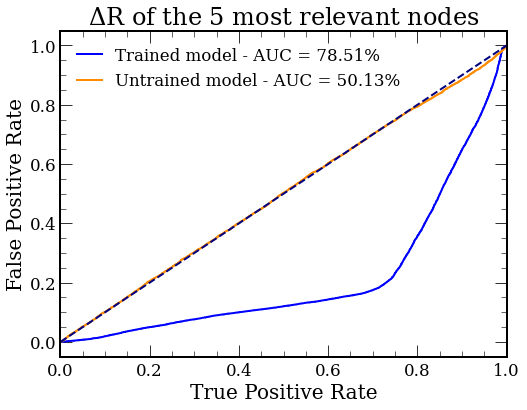

<Figure size 720x720 with 0 Axes>

In [236]:
# Compute ROC curve and ROC area for each class    

score = dr_top_trained + dr_qcd_trained
label = [1] * len(dr_top_trained) + [0] * len(dr_qcd_trained)
fpr_trained, tpr_trained, _ = roc_curve(label, score)
roc_auc = auc(fpr_trained, tpr_trained)

score = dr_top_untrained + dr_qcd_untrained
label = [1] * len(dr_top_untrained) + [0] * len(dr_qcd_untrained)
fpr_untrained, tpr_untrained, _ = roc_curve(label, score)
roc_auc_untrained = auc(fpr_untrained, tpr_untrained)

fig, ax = plt.subplots(figsize=(8,6))
ax.plot(
    tpr_trained,
    fpr_trained,
    color="blue",
    lw=2,
    label=f"Trained model - AUC = {round(auc(fpr_trained, tpr_trained)*100,2)}%",
)
ax.plot(
    tpr_untrained,
    fpr_untrained,
    color="darkorange",
    lw=2,
    label=f"Untrained model - AUC = {round(auc(fpr_untrained, tpr_untrained)*100,2)}%",
)
plt.plot([0, 1], [0, 1], color="navy", lw=2, linestyle="--")
plt.xlim([0.0, 1.0])
# plt.ylim([0.0, 1])
plt.ylabel("False Positive Rate")
plt.xlabel("True Positive Rate")
# plt.yscale('log')
plt.title("$\Delta$R of the 5 most relevant nodes")
plt.legend(loc="upper left")
plt.show()
plt.savefig('Roc_curve.pdf');

# Aftermath

In [203]:
! ls

ParticleNet          R_edges.pkl          paper
ParticleNet_2        batch_p4.pkl         particlenet.ipynb
ParticleNet_3        edge_index.pkl       roc
ParticleNet_6        fastjet.ipynb        y_score.pt
ParticleNet_dropout1 k12_d2.pdf           y_test.pt


'texgyreheros-regular.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.


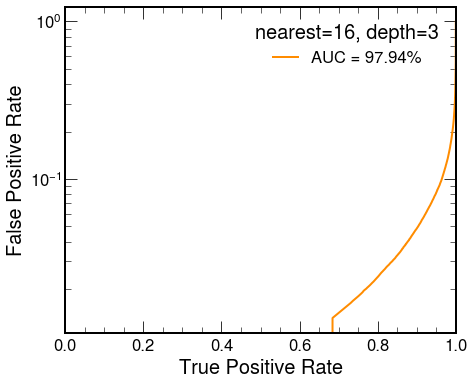

In [169]:
fig, ax = plt.subplots(figsize=[7,6])
y_score = torch.load(f"roc/k16_d3/y_score.pt")
y_test = torch.load(f"roc/k16_d3/y_test.pt")

fpr, tpr, _ = roc_curve(y_test, y_score)

ax.plot(
    tpr,
    fpr,
    color="darkorange",
    lw=2,
    label=f"AUC = {round(auc(fpr, tpr)*100,2)}%",
)
plt.xlim([0.0, 1.0])
plt.ylabel("False Positive Rate")
plt.xlabel("True Positive Rate")
plt.yscale("log")
plt.legend(title='nearest=16, depth=3', loc="upper right")
plt.savefig('k12_d2.pdf')

In [204]:
models = os.listdir('roc')
print(models)
models = [f'{i}' for i in models][1:]
models = sorted(models) 
print(models)

['.DS_Store', 'k8_d3', 'k16_d2', 'k12_d3', 'k8_d2', 'k12_d2', 'k16_d3', 'k4_d3', 'k4_d2']
['k12_d2', 'k12_d3', 'k16_d2', 'k16_d3', 'k4_d2', 'k4_d3', 'k8_d2', 'k8_d3']


'texgyreheros-regular.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.


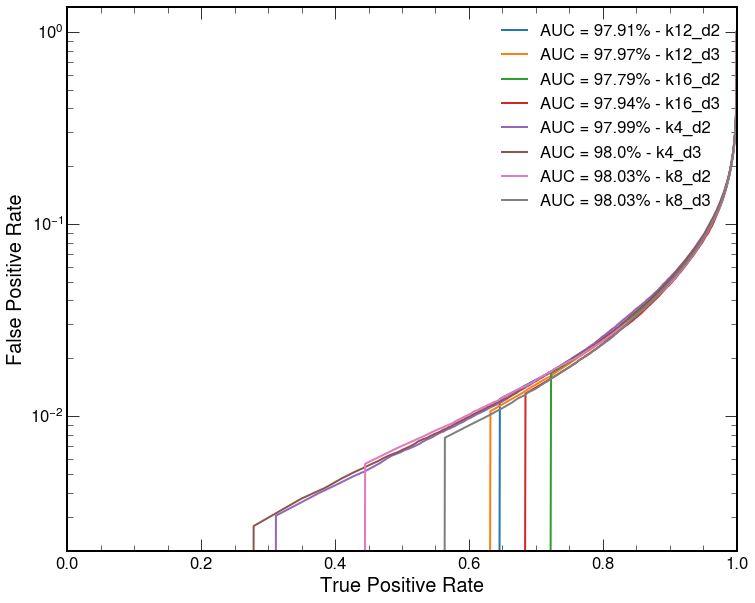

In [205]:
fig, ax = plt.subplots(figsize=[12,10])

for model in models:
    y_score = torch.load(f"roc/{model}/y_score.pt")
    y_test = torch.load(f"roc/{model}/y_test.pt")
    
    fpr, tpr, _ = roc_curve(y_test, y_score)

    ax.plot(
        tpr,
        fpr,
#         color="darkorange",
        lw=2,
        label=f"AUC = {round(auc(fpr, tpr)*100,2)}% - {model}",
    )
plt.xlim([0.0, 1.0])
plt.ylabel("False Positive Rate")
plt.xlabel("True Positive Rate")
plt.yscale("log")
plt.legend(loc="upper right")
plt.savefig('k12_d2.pdf')

# deltaR

<ipython-input-221-988dff06ccbc>:17: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.
  ax.set_ylim(0,20)


Text(0, 0.5, 'Normalized counts')

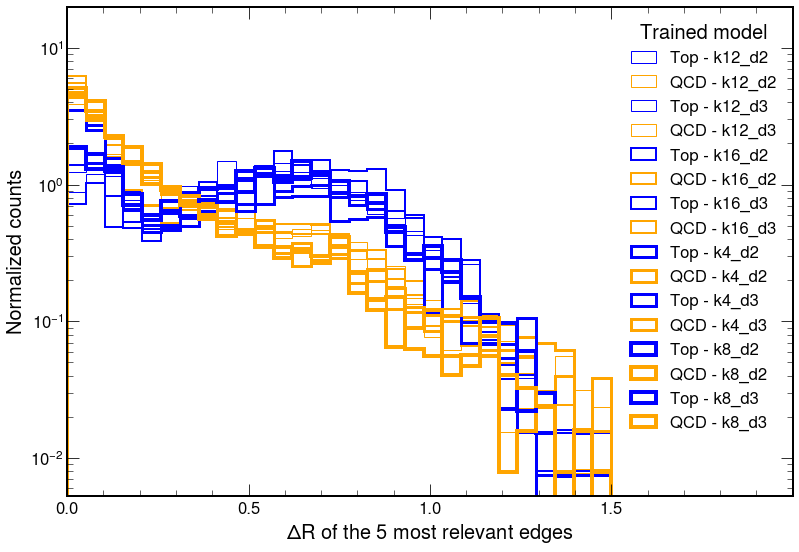

In [221]:
# make the plot
fig, ax = plt.subplots(figsize=(13,9))
ccc = 1
for i, model in enumerate(models):
    with open(f"roc/{model}/dr_best_top.pkl", 'rb') as f:
        dr_best_top = pkl.load(f) 
    with open(f"roc/{model}/dr_best_qcd.pkl", 'rb') as f:
        dr_best_qcd = pkl.load(f) 

    ax.hist(dr_best_top, bins=np.linspace(0, 1.5, 30), label=f'Top - {model}', color="Blue", histtype='step', linewidth=ccc, density=True)
    ax.hist(dr_best_qcd, bins=np.linspace(0, 1.5, 30), label=f'QCD - {model}', color="Orange", histtype='step', linewidth=ccc, density=True)
    if i%2:
        ccc+=1

ax.legend(title='Trained model')
ax.set_yscale('log') 
ax.set_ylim(0,20)
ax.set_xlim(0,2)
ax.set_xticks([0,0.5,1,1.5])
ax.set_xlabel('$\Delta$R of the 5 most relevant edges')
ax.set_ylabel('Normalized counts')

<ipython-input-222-6c55b19aeecc>:17: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.
  ax.set_ylim(0,20)


Text(0, 0.5, 'Normalized counts')

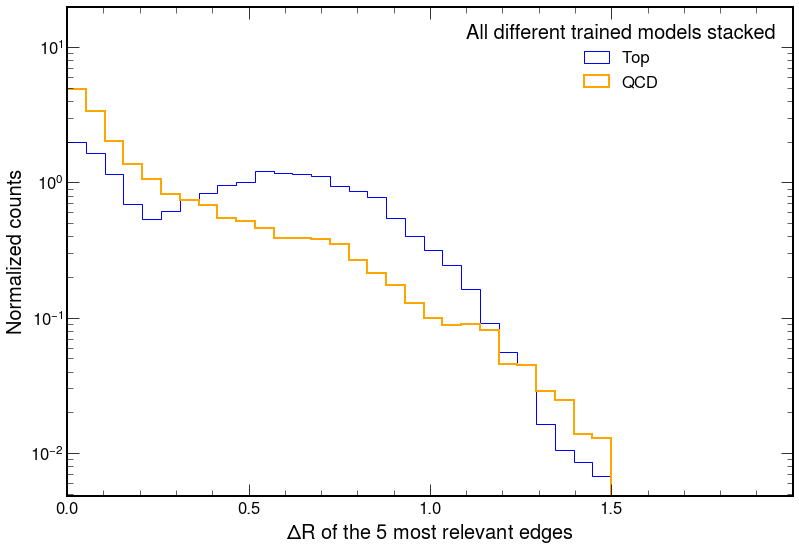

In [222]:
# make the plot
fig, ax = plt.subplots(figsize=(13,9))
dr_best_qcd_all, dr_best_top_all = [], []
for model in models:
    with open(f"roc/{model}/dr_best_top.pkl", 'rb') as f:
        dr_best_top = pkl.load(f) 
    with open(f"roc/{model}/dr_best_qcd.pkl", 'rb') as f:
        dr_best_qcd = pkl.load(f) 
    dr_best_qcd_all += dr_best_qcd
    dr_best_top_all += dr_best_top
    
ax.hist(dr_best_top_all, bins=np.linspace(0, 1.5, 30), label=f'Top', color="Blue", histtype='step', linewidth=1, density=True)
ax.hist(dr_best_qcd_all, bins=np.linspace(0, 1.5, 30), label=f'QCD', color="Orange", histtype='step', linewidth=2, density=True)

ax.legend(title='All different trained models stacked')
ax.set_yscale('log') 
ax.set_ylim(0,20)
ax.set_xlim(0,2)
ax.set_xticks([0,0.5,1,1.5])
ax.set_xlabel('$\Delta$R of the 5 most relevant edges')
ax.set_ylabel('Normalized counts')

# Mij

<ipython-input-223-ab9ede31015d>:16: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.
  ax.set_ylim(0,20)


Text(0, 0.5, 'Normalized counts')

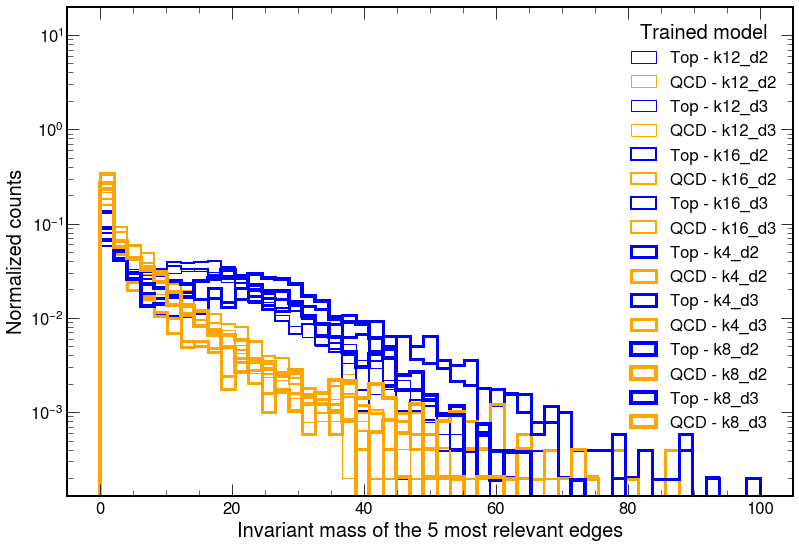

In [223]:
# make the plot
fig, ax = plt.subplots(figsize=(13,9))
ccc = 1
for i, model in enumerate(models):
    with open(f"roc/{model}/Mij_best_top.pkl", 'rb') as f:
        Mij_best_top = pkl.load(f) 
    with open(f"roc/{model}/Mij_best_qcd.pkl", 'rb') as f:
        Mij_best_qcd = pkl.load(f) 

    ax.hist(Mij_best_top, bins=np.linspace(0, 100), label=f'Top - {model}', color="Blue", histtype='step', linewidth=ccc, density=True)
    ax.hist(Mij_best_qcd, bins=np.linspace(0, 100), label=f'QCD - {model}', color="Orange", histtype='step', linewidth=ccc, density=True)
    if i%2:
        ccc+=1
ax.legend(title='Trained model')
ax.set_yscale('log') 
ax.set_ylim(0,20)
ax.set_xlabel('Invariant mass of the 5 most relevant edges')
ax.set_ylabel('Normalized counts')

<ipython-input-224-3968471df179>:17: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.
  ax.set_ylim(0,20)


Text(0, 0.5, 'Normalized counts')

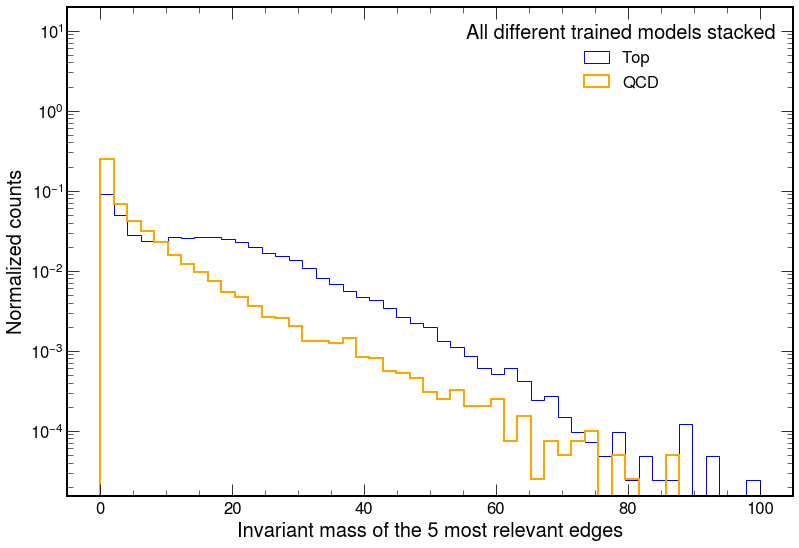

In [224]:
# make the plot
fig, ax = plt.subplots(figsize=(13,9))
Mij_best_qcd_all, Mij_best_top_all = [], []
for model in models:
    with open(f"roc/{model}/Mij_best_top.pkl", 'rb') as f:
        Mij_best_top = pkl.load(f) 
    with open(f"roc/{model}/Mij_best_qcd.pkl", 'rb') as f:
        Mij_best_qcd = pkl.load(f) 
    Mij_best_qcd_all += Mij_best_qcd
    Mij_best_top_all += Mij_best_top
    
ax.hist(Mij_best_top_all, bins=np.linspace(0, 100), label=f'Top', color="Blue", histtype='step', linewidth=1, density=True)
ax.hist(Mij_best_qcd_all, bins=np.linspace(0, 100), label=f'QCD', color="Orange", histtype='step', linewidth=2, density=True)

ax.legend(title='All different trained models stacked')
ax.set_yscale('log') 
ax.set_ylim(0,20)
ax.set_xlabel('Invariant mass of the 5 most relevant edges')
ax.set_ylabel('Normalized counts')

## Scaling_up

In [171]:
ls roc/k16_d2

Mij_best_qcd.pkl       dr_best_top.pkl        y_score.pt
Mij_best_top.pkl       qcd_fraction_best.pkl  y_test.pt
dr_best_qcd.pkl        top_fraction_best.pkl


Text(0, 0.5, '$N_{edges \\ between \\ subjets}$ / $N_{edges}$')

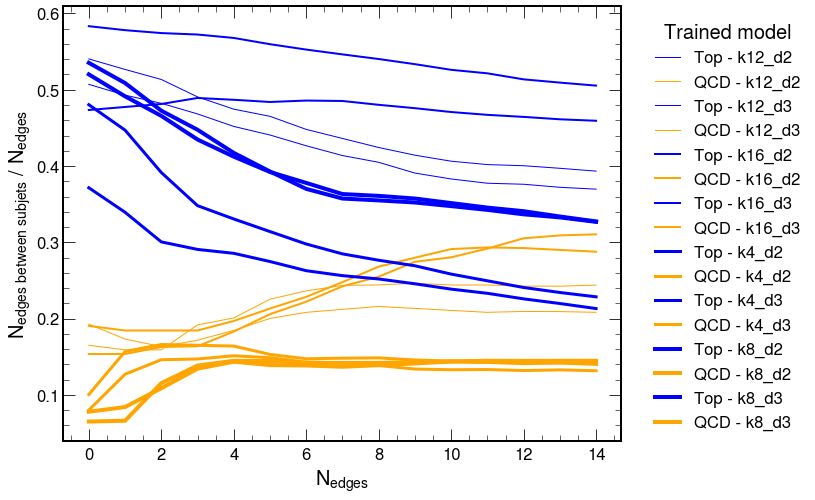

In [264]:
# make the plot
fig, ax = plt.subplots(figsize=(10,8))
ccc = 1
for i, model in enumerate(models):
    with open(f"roc/{model}/top_fraction_best.pkl", 'rb') as f:
        top_fraction_best = pkl.load(f) 
    with open(f"roc/{model}/qcd_fraction_best.pkl", 'rb') as f:
        qcd_fraction_best = pkl.load(f) 

    ax.plot(range(len(top_fraction_best)), top_fraction_best, label=f'Top - {model}', color="Blue", linewidth=ccc)
    ax.plot(range(len(qcd_fraction_best)), qcd_fraction_best, label=f'QCD - {model}', color="Orange", linewidth=ccc)

    if i%2:
        ccc+=1
        
ax.legend(title='Trained model', loc="upper right", bbox_to_anchor=(1.35,1))
# ax.set_yscale('log') 
ax.set_xlabel(r'$N_{edges}$', fontsize=20)
ax.set_ylabel(r'$N_{edges \ between \ subjets}$ / $N_{edges}$', fontsize=20)

Text(0, 0.5, '$N_{edges \\ between \\ subjets}$ / $N_{edges}$')

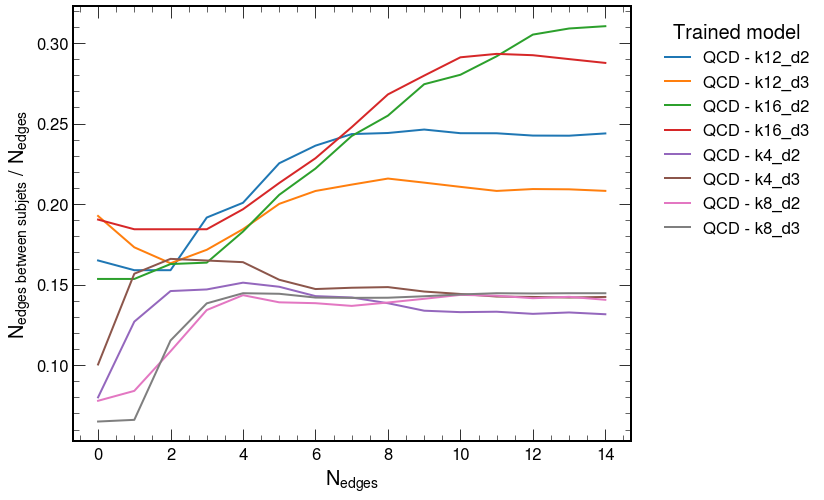

In [269]:
# make the plot
fig, ax = plt.subplots(figsize=(10,8))
ccc = 1
for i, model in enumerate(models):
    with open(f"roc/{model}/top_fraction_best.pkl", 'rb') as f:
        top_fraction_best = pkl.load(f) 
    with open(f"roc/{model}/qcd_fraction_best.pkl", 'rb') as f:
        qcd_fraction_best = pkl.load(f) 

#     ax.plot(range(len(top_fraction_best)), top_fraction_best, label=f'Top - {model}', linewidth=2)
    ax.plot(range(len(qcd_fraction_best)), qcd_fraction_best, label=f'QCD - {model}', linewidth=2)

    if i%2:
        ccc+=1
        
ax.legend(title='Trained model', loc="upper right", bbox_to_anchor=(1.35,1))
# ax.set_yscale('log') 
ax.set_xlabel(r'$N_{edges}$', fontsize=20)
ax.set_ylabel(r'$N_{edges \ between \ subjets}$ / $N_{edges}$', fontsize=20)

Text(0, 0.5, '$N_{edges \\ between \\ subjets}$ / $N_{edges}$')

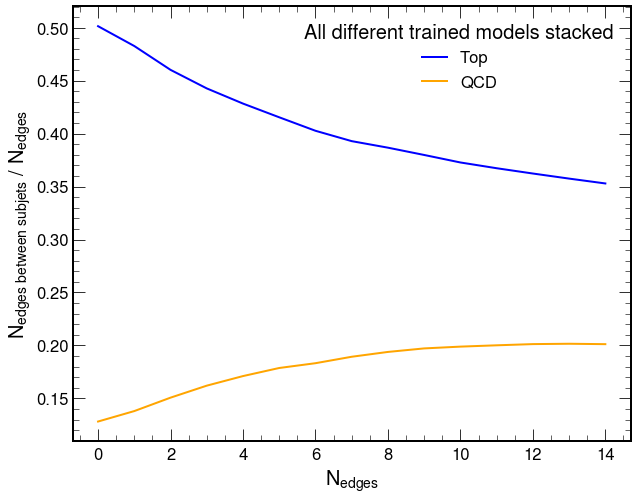

In [266]:
# make the plot
fig, ax = plt.subplots(figsize=(10,8))

for i, model in enumerate(models):
    with open(f"roc/{model}/top_fraction_best.pkl", 'rb') as f:
        top_fraction_best = pkl.load(f) 
    with open(f"roc/{model}/qcd_fraction_best.pkl", 'rb') as f:
        qcd_fraction_best = pkl.load(f) 

        if i == 0:
            top_fraction_best_all = top_fraction_best
            qcd_fraction_best_all = qcd_fraction_best
        else:
            top_fraction_best_all += top_fraction_best
            qcd_fraction_best_all += qcd_fraction_best
            
ax.plot(range(len(top_fraction_best_all)), top_fraction_best_all/len(models), label=f'Top', color="Blue", linewidth=2)
ax.plot(range(len(qcd_fraction_best_all)), qcd_fraction_best_all/len(models), label=f'QCD', color="Orange", linewidth=2)
    
ax.legend(title='All different trained models stacked', loc='upper right')
# ax.set_yscale('log') 
ax.set_xlabel(r'$N_{edges}$', fontsize=20)
ax.set_ylabel(r'$N_{edges \ between \ subjets}$ / $N_{edges}$', fontsize=20)